# Goal
## We predict TotalCost for each Top-25 drug entry to understand how cost varies across payer types, drug categories, and utilization measures.

In [29]:
# Read data

import pandas as pd
import numpy as np
from pathlib import Path

DATA = Path("../data")
df = pd.read_csv(DATA / "top_cost.csv")
df.head(), df.shape


(             TableType Top25Type  Year Drug_Category   Payer_Type  Rank  \
 0  Top 25 List Overall      Cost  2021      Biologic  All Payers    1.0   
 1  Top 25 List Overall      Cost  2021      Biologic  All Payers    2.0   
 2  Top 25 List Overall      Cost  2021      Biologic  All Payers    3.0   
 3  Top 25 List Overall      Cost  2021      Biologic  All Payers    4.0   
 4  Top 25 List Overall      Cost  2021      Biologic  All Payers    5.0   
 
    National_Drug_Code                     Drug_Name NumberofPrescriptions  \
 0        7.405540e+07                Humira (2 Pen)                98,904   
 1        5.789401e+10                       Stelara                22,973   
 2        5.840600e+10              Enbrel SureClick                70,151   
 3        7.443390e+07                Humira (2 Pen)                66,878   
 4        7.806394e+07  Cosentyx Sensoready (300 MG)                56,823   
 
   NumberofIndividuals     TotalCost AverageCostperUnit  \
 0           

In [30]:
# Convert the money column from "$1,234" to a numerical value.

def money_to_float(s: pd.Series) -> pd.Series:
    return pd.to_numeric(
        s.astype(str).str.replace(r"[$,]", "", regex=True),
        errors="coerce"
    )

for col in ["TotalCost", "AverageCostperUnit"]:
    if col in df.columns:
        df[col] = money_to_float(df[col])

df[["TotalCost","AverageCostperUnit"]].head()


,TotalCost,AverageCostperUnit
0,658455118,2767.33
1,487220554,20287.33
2,400942148,1332.09
3,386458748,2336.77
4,291401313,2303.67


## Preprocessing

We imputed missing numeric values using the median, imputed missing categorical values using the most frequent category, and applied one-hot encoding to categorical variables. We excluded high-cardinality identifier fields (e.g., drug name / NDC) to avoid sparse, overly specific features.

In [31]:
# Select the target variable y and the features X. (Predict TotalCost)

target = "TotalCost"

drop_cols = [c for c in ["Drug_Name", "National_Drug_Code"] if c in df.columns]

X = df.drop(columns=drop_cols + [target])
y = df[target]

mask = y.notna()
X, y = X.loc[mask], y.loc[mask]

X.head(), y.describe()


(             TableType Top25Type  Year Drug_Category   Payer_Type  Rank  \
 0  Top 25 List Overall      Cost  2021      Biologic  All Payers    1.0   
 1  Top 25 List Overall      Cost  2021      Biologic  All Payers    2.0   
 2  Top 25 List Overall      Cost  2021      Biologic  All Payers    3.0   
 3  Top 25 List Overall      Cost  2021      Biologic  All Payers    4.0   
 4  Top 25 List Overall      Cost  2021      Biologic  All Payers    5.0   
 
   NumberofPrescriptions NumberofIndividuals  AverageCostperUnit  \
 0                98,904              13,579             2767.33   
 1                22,973               4,418            20287.33   
 2                70,151               9,754             1332.09   
 3                66,878               9,062             2336.77   
 4                56,823               8,015             2303.67   
 
    AverageDispensedUnitsPerFill DrugUnitofMeasure Out-of-Pocket Median  \
 0                             2                EA       

In [32]:
# Preprocessing + Data splitting

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include="number").columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape



((196, 15), (50, 15))

## Models Compared

We compared three models: (1) a baseline mean predictor, (2) Ridge regression as a linear model baseline, and (3) Random Forest to capture nonlinear relationships and interactions.

In [33]:
# Comparison of three models (Baseline / Ridge / RandomForest) + 5-fold cross-validation

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(rmse, greater_is_better=False),
    "R2": make_scorer(r2_score),
}

models = {
    "BaselineMean": DummyRegressor(strategy="mean"),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for name, model in models.items():
    pipe = Pipeline([("preprocess", preprocess), ("model", model)])
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring)
    rows.append({
        "model": name,
        "cv_MAE": -scores["test_MAE"].mean(),
        "cv_RMSE": -scores["test_RMSE"].mean(),
        "cv_R2": scores["test_R2"].mean(),
    })

cv_results = pd.DataFrame(rows).sort_values("cv_RMSE")
cv_results


,model,cv_MAE,cv_RMSE,cv_R2
2,RandomForest,4.343612e+07,8.780269e+07,0.860170
1,Ridge,6.981961e+07,1.041118e+08,0.786419
0,BaselineMean,1.764942e+08,2.392042e+08,-0.037898


## Evaluation & Final Model

Using 5-fold cross-validation, Random Forest achieved the best RMSE and highest R², so we selected it as the final model. On the held-out test set, the Random Forest achieved MAE ≈ 3.05×10⁷, RMSE ≈ 5.40×10⁷, and R² ≈ 0.950. Diagnostic plots (Predicted vs True and Residuals) are shown below.

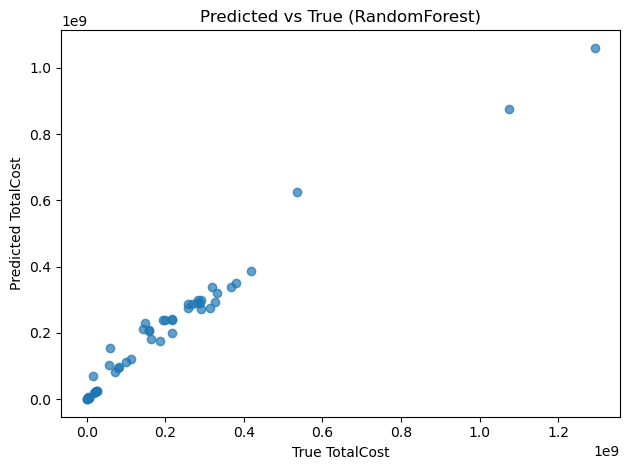

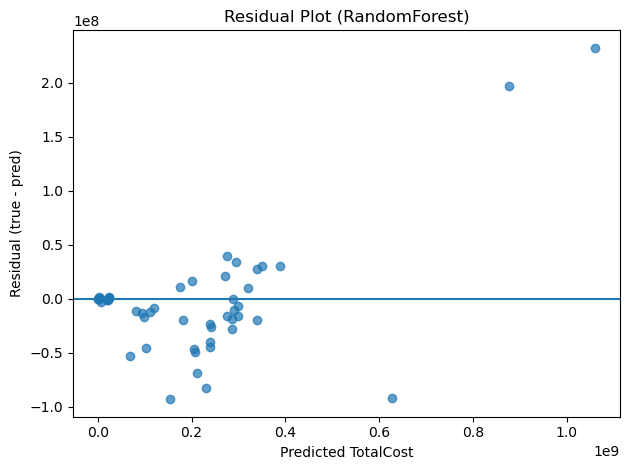

,model,MAE,RMSE,R2
0,RandomForest,3.054251e+07,5.397786e+07,0.949733


In [34]:
# Run the best model on the test set + save the results and plots

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

best_name = cv_results.iloc[0]["model"]
best_pipe = Pipeline([("preprocess", preprocess), ("model", models[best_name])])
best_pipe.fit(X_train, y_train)

pred = best_pipe.predict(X_test)

test_metrics = pd.DataFrame([{
    "model": best_name,
    "MAE": float(mean_absolute_error(y_test, pred)),
    "RMSE": float(np.sqrt(mean_squared_error(y_test, pred))),
    "R2": float(r2_score(y_test, pred)),
}])

Path("../results").mkdir(exist_ok=True)
cv_results.to_csv("../results/model_cv_results.csv", index=False)
test_metrics.to_csv("../results/model_test_metrics.csv", index=False)

Path("../images").mkdir(exist_ok=True)

plt.figure()
plt.scatter(y_test, pred, alpha=0.7)
plt.xlabel("True TotalCost")
plt.ylabel("Predicted TotalCost")
plt.title(f"Predicted vs True ({best_name})")
plt.tight_layout()
plt.savefig("../images/pred_vs_true.png", dpi=200)
plt.show()

plt.figure()
plt.scatter(pred, y_test - pred, alpha=0.7)
plt.axhline(0)
plt.xlabel("Predicted TotalCost")
plt.ylabel("Residual (true - pred)")
plt.title(f"Residual Plot ({best_name})")
plt.tight_layout()
plt.savefig("../images/residuals.png", dpi=200)
plt.show()

test_metrics
